# Imports and Set-up

This workbook was used to explore Tf-idf modeling of the love_snippets corpus. The workbook currently has binary=True set for the tfidf model.  However, during the project I looked at both binary=False and binary=True.  When binary=True, the tf term in the tf-idf is 0 or 1 rather than the calculated frequency in the individual document.

The cell below shifts the working directory to facilitate importing functions stored in the src module.  Other paths used in the file rely on this too.

In [1]:
cd ..

/Users/sean/CloudStation/Metis/projects/project4


In [2]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as plt
from matplotlib import animation
%matplotlib inline

In [3]:
# Get the collection of n(=1)-sentence snippets with the word 'love'
love_snippets = pd.read_pickle('./data/processed/love_snippets')

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.  In the end I left these documents in the corpus.

In [4]:
love_snippets.loc[[132, 2382]]

,transcript,url,sentences,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,57,12,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,109,15,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [5]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

# Topic Modeling

In [56]:
# Topic modeling
# Vectorize
tfidf1 = TfidfVectorizer(stop_words='english', lowercase=True,binary=True)
doc_words_tfidf1 = tfidf1.fit_transform(love_snippets.love)

# Dimension Reduction
tfidf_lsa=[]
tfidf_doc_topic=[]
for i in range(2,7):
    tfidf_lsa.append(TruncatedSVD(i))
    tfidf_doc_topic.append(tfidf_lsa[i-2].fit_transform(doc_words_tfidf1))
    print(int(i),'topics variance ratios:',tfidf_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.00568481 0.00852852]
3 topics variance ratios: [0.0056849  0.00852935 0.00554939]
4 topics variance ratios: [0.00568492 0.00852844 0.00561362 0.00453071]
5 topics variance ratios: [0.00568491 0.00852845 0.00561185 0.00451403 0.00450717]
6 topics variance ratios: [0.00568487 0.00852794 0.00561178 0.00453842 0.00449013 0.00393404]


# The 2-Topic Result

In [7]:
display_topics(tfidf_lsa[0], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, wires, puzzle, thirds, vodka, mythology, labor, imagining, phrase, action


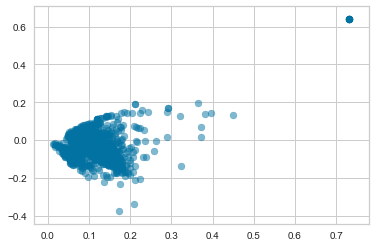

In [8]:
plt.scatter(tfidf_doc_topic[0][:,0],tfidf_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

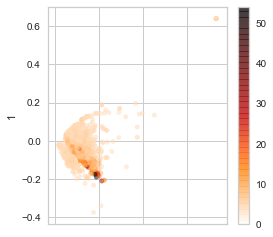

In [9]:
df=pd.DataFrame(tfidf_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

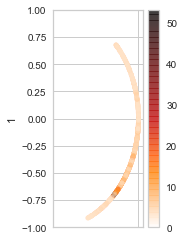

In [10]:
df = pd.DataFrame(normalize(tfidf_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

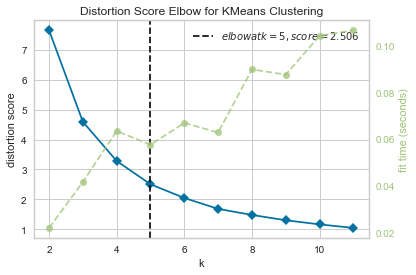

In [11]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(tfidf_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [12]:
visualizer.elbow_value_

5

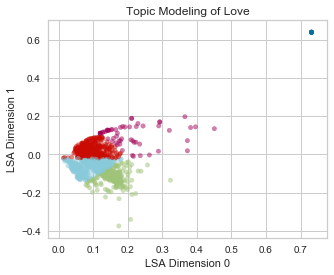

In [13]:
df=pd.DataFrame(tfidf_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [14]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [0.09420863 0.01629772]
g [ 0.15533372 -0.12229784]
b [0.73172764 0.63865815]
c [ 0.09425627 -0.05941087]
m [0.20929614 0.10174589]


Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [15]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,tfidf_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.107703,0.045299,0.925170,0.055386,0.190289
1,0.076113,0.094652,0.880356,0.069745,0.139810
2,0.032987,0.158699,0.858948,0.096676,0.110602
3,0.096042,0.065102,0.951556,0.023186,0.207716
4,0.206403,0.055529,0.974276,0.142625,0.271250


Show the snippets from the 4 (euclidean distance) closest documents:

In [16]:
doc_topic = tfidf_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.09420863 0.01629772] color= r
596 : [0.09384904 0.01925807] (Music) Beauty and seduction is nature's tools for survival, because we protect what we fall in love with.
636 : [0.09080054 0.01647052] Romo's a robot that uses a device you already know and love — your iPhone — as his brain.
742 : [0.09085069 0.01554439] I'm here with my friends, I love traveling, being a beauty pageant queen. " That was so lovely.
961 : [0.09291272 0.01971161] I'd love to sit down with him, wherever he is, and share with him how much the time I spent on Smoky Mountain inspired me.


Cluster centered at: [ 0.15533372 -0.12229784] color= g
366 : [ 0.15424235 -0.1221495 ] "(Laughter)So I'm a researcher-storyteller, and I'm going to talk to you today — we're talking about expanding perception — and so I want to talk to you and tell some stories about a piece of my research that fundamentally expanded my perception and really actually changed the way that I live and love and work and pare

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

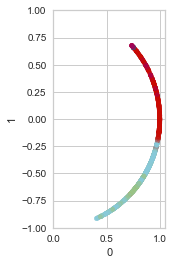

In [17]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [18]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.09420863 0.01629772] color= r
545 : [0.10549457 0.01830256] This grew into a passion for finding things, a love for the past and archaeology.
71 : [0.10290642 0.01769868] In the Summer of Love, in 1967, two million people, children, died of smallpox.
742 : [0.09085069 0.01554439] I'm here with my friends, I love traveling, being a beauty pageant queen. " That was so lovely.
205 : [0.08370303 0.01474723] And now I love swimming. And now I love languages. And if any of you are interested in that, I would love to speak with you. But I ask a lot of questions, and I would love your advice.


Cluster centered at: [ 0.15533372 -0.12229784] color= g
939 : [ 0.15031236 -0.11828682] I work a lot, very hard, and I love it. I love working. I just know that I'm not built for failure, and I just know that I love the hum. I love working, right? I love that hum. So what do you do when the thing you do, the work you love, starts to taste like dust?Now, I know somebody's out ther

Now clustering on the normalized df dataframe:

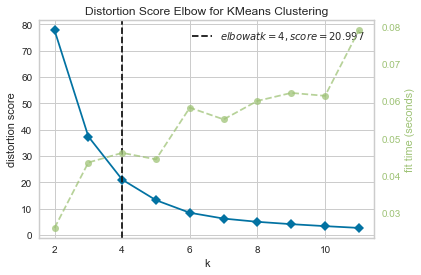

In [19]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

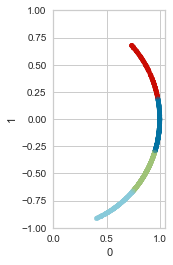

In [20]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [21]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.87656225 0.44881587] color= r
916 : [0.88962224 0.45669713] (Laughter)That's an "I love Dad" T-shirt. Sneakerheads love Jordans.
708 : [0.89080073 0.45439416] Of course, I would love to pave this street for cars.
111 : [0.8894083  0.45711364] ♫♫ Nothing more to say ♫♫ and only love can see us through, anyway.
930 : [0.88830307 0.45925772] Personally, I love handicrafts, especially handicrafts that are woven around a story.


Cluster centered at: [ 0.86277401 -0.49191628] color= g
51 : [ 0.86907726 -0.49467637] I love that Leilei said that the way of helping those who are suffering badly on the physical plane or on other planes is having a good time, doing it by having a good time. It's really lovely.
766 : [ 0.86909944 -0.49463741] But sometimes a father's love can be misconstrued as controlling, and conversely, the scope of his son's ambition can seem like some pie-in-the-sky fantasy. to the world ♪♪ I hope that someone gets my ♪♪ I hope that someone gets my ♪♪

# The 3-topic Result

In [22]:
display_topics(tfidf_lsa[1], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, mythology, thirds, wires, vodka, puzzle, labor, imagining, phrase, action

Topic  2
loved, really, love, ones, family, place, concert, machine, told, cook, big, lost, iphone, sailing


In [23]:
tfidf_doc_topic[1]

array([[ 0.14647825, -0.07834437,  0.03738772],
       [ 0.15634455, -0.02743555, -0.04541268],
       [ 0.12264901,  0.03314042, -0.01713273],
       ...,
       [ 0.11307394,  0.03989642, -0.01650935],
       [ 0.09658043, -0.02300636, -0.05835936],
       [ 0.13771066,  0.02611903, -0.01004437]])

In [24]:
from mpl_toolkits.mplot3d import Axes3D

In [25]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(tfidf_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

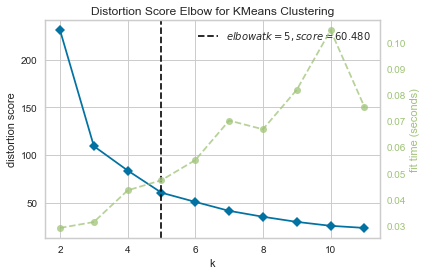

In [26]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [27]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

You may have to execute the next cell 3 times before it shows the figure.

<IPython.core.display.Javascript object>


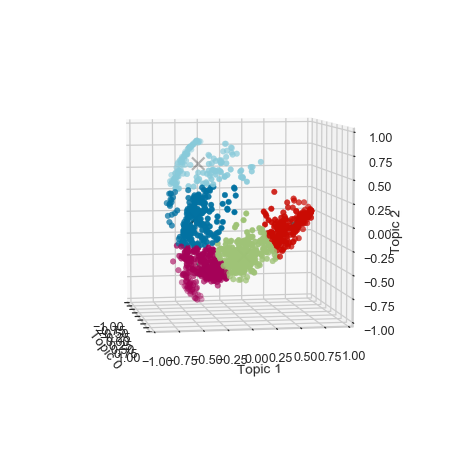

In [30]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=100,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

So, what do the clusters mean?

In [31]:
doc_topic = tfidf_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.86828565 0.44717605 0.0347425 ] color= r
208 : [0.8798121  0.47470202 0.02426252] In this case misery truly does love company.
642 : [0.89370274 0.44861404 0.00639211] When I made love with my wife, I had no sperm that came out of me; I had blood.
111 : [0.88940777 0.45711358 0.00099543] ♫♫ Nothing more to say ♫♫ and only love can see us through, anyway.
803 : [0.8705021  0.49122301 0.03043107] The first is it made me fall in love with Africa.


Cluster centered at: [ 0.93803859 -0.07082688 -0.28008928] color= g
1081 : [ 0.95275669 -0.08452545 -0.29173643] He goes, "I love what you do. I love the philosophers: Plato, Socrates, Habermas, Heidegger. I love technology. I love Joel, don't get me wrong, but I'm not saying we go to Joel.
468 : [ 0.94943838 -0.08593714 -0.30196287] (Laughter)And I love that moment in this video, because before it became a shared experience, it was something that was maybe a little bit scary, or something that was at least confusing to 

## DBSCAN Clustering

In [32]:
from sklearn.cluster import DBSCAN

In [33]:
db = DBSCAN(eps=0.055, min_samples=5).fit(df)
labels = db.labels_
np.unique(labels,return_counts=True)
# labels = hdbscan.HDBSCAN(
#     min_samples=10,
#     min_cluster_size=500,
# ).fit_predict(clusterable_embedding)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]),
 array([104, 854,  45,  41,   6,  62,  13,   5,   7,   5]))

In [34]:
cmap = {-1: 'k', 0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow',10:'fuchsia',11:'purple',12:'brown'}
col = pd.DataFrame(np.array([db.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


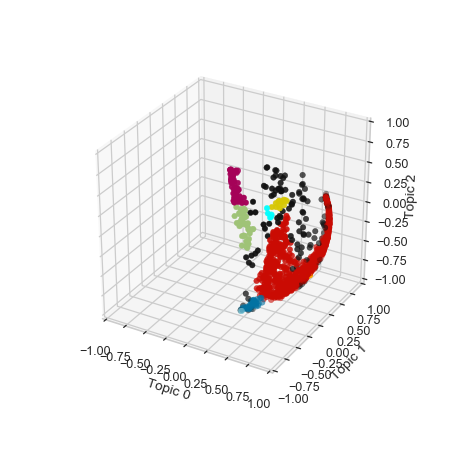

In [35]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=100,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## MeanShift Clustering

In [36]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [37]:
# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(df, quantile=0.09)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df)
cluster_centers = ms.cluster_centers_
np.unique(ms.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([433, 180, 212, 118,  51,  57,  91]))

<IPython.core.display.Javascript object>


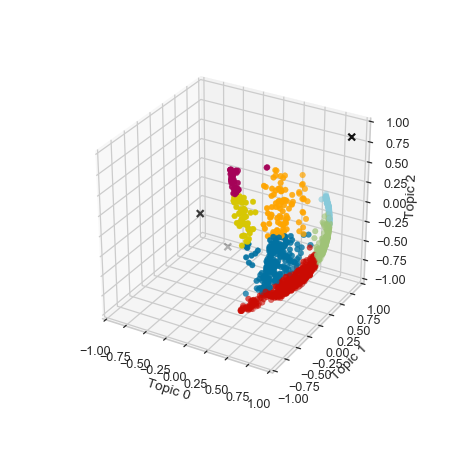

In [38]:
%matplotlib notebook
col = pd.DataFrame(np.array([ms.labels_])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## Hierarchical clustering

In [39]:
from sklearn.cluster import AgglomerativeClustering

In [40]:
# linkage can be 'ward', 'average' or 'complete'
hc = AgglomerativeClustering(linkage='average', n_clusters=6)
hc.fit(df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=6,
                        pooling_func='deprecated')

<IPython.core.display.Javascript object>


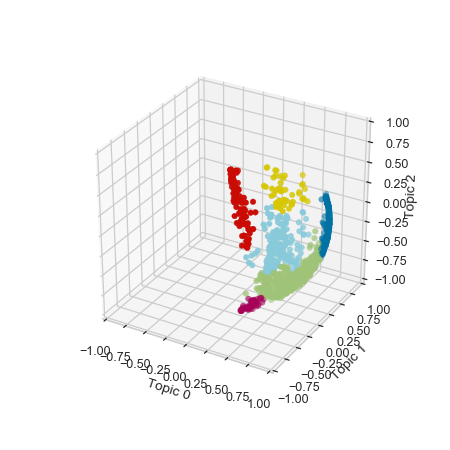

In [41]:
%matplotlib notebook
col = pd.DataFrame(np.array([hc.labels_])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

## Spectral Clustering

In [42]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=6)
labels = sc.fit_predict(df)

<IPython.core.display.Javascript object>


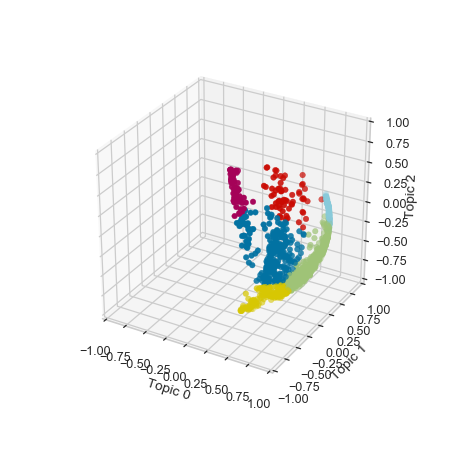

In [43]:
%matplotlib notebook
col = pd.DataFrame(np.array([labels])).transpose()[0].map(cmap)
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
#            marker='x',s=30,c='k')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

# The 4-Topic Result

In [44]:
display_topics(tfidf_lsa[2], tfidf1.get_feature_names(), 14)


Topic  0
love, loved, people, know, really, just, laughter, like, things, thing, think, going, said, ve

Topic  1
love, picture, dearly, complexity, jc, thirds, puzzle, mythology, vodka, wires, labor, imagining, phrase, action

Topic  2
loved, really, love, ones, family, place, concert, machine, told, cook, big, iphone, lost, sailing

Topic  3
laughter, picture, lovely, right, make, applause, loved, little, idea, internet, told, basically, got, true


In [45]:
doc_topic = tfidf_doc_topic[2]
df = pd.DataFrame(normalize(tfidf_doc_topic[2]))

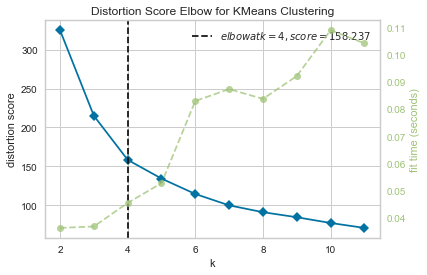

In [46]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [47]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


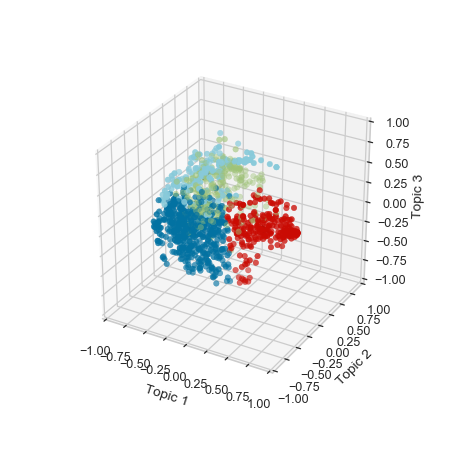

In [48]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=50,c='k')
ax.scatter(df[1],df[2],df[3],c=col)
ax.set_xlabel('\nTopic 1')
ax.set_ylabel('\nTopic 2')
ax.set_zlabel('\nTopic 3')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

I've commented out the anim.save line of code so the mp4 video file doesn't have to be rendered to use see the animation below:

<IPython.core.display.Javascript object>


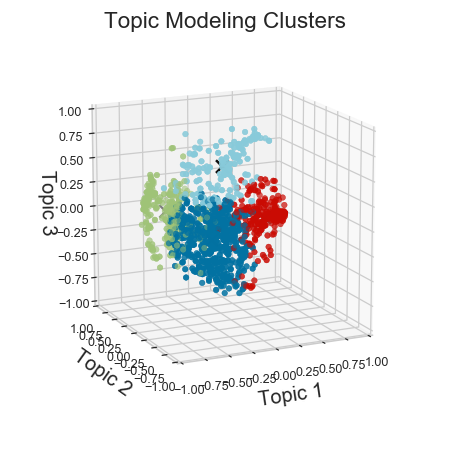

In [51]:
%matplotlib notebook
# Set up formatting for the movie files
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/Cellar/ffmpeg/4.2.1_2/bin/ffmpeg'
Writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Sean Davern'),\
                                bitrate=-1, extra_args=['-vcodec','libx264'])

# Create a figure and a 3D Axes
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, title="Topic Modeling Clusters")
ax.title.set_size(18)
ax.set_xlabel('\nTopic 1', fontsize=16)
ax.set_ylabel('\nTopic 2', fontsize=16)
ax.set_zlabel('\nTopic 3', fontsize=16)
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
# Create an init function and the animate functions.
# Both are explained in the tutorial:
# http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/
# Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function.
def init():
    ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=100,c='k')
    ax.scatter(df[1],df[2],df[3],c=col)
    ax.dist = 12
    return fig,

def animate(i):
    ax.view_init(elev=15, azim=-45+i)
    ax.dist = 12
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=10, blit=True,
                               repeat=True)
# Save
# anim.save('./reports/figures/tfidf_binary-lsa_animation.mp4',\
#           writer = Writer, dpi=600)

In [52]:
doc_topic = tfidf_doc_topic[2]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.87141368  0.37197185  0.01149698 -0.03226544] color= r
943 : [ 0.93317607  0.35835579  0.00098043 -0.02761487] We need shelter and love. Love is great, too.
310 : [0.91567165 0.40174175 0.00455269 0.0113259 ] They love Namibia for its beautiful dunes, that are even taller than the Empire State Building.
931 : [ 0.91620681  0.39989446 -0.02540586 -0.00201116] We love eye-popping color, and we try to bring this eye-popping color underwater with us.
953 : [ 0.89570244  0.44225808 -0.02298457 -0.03995791] But I love it for a totally different reason.


Cluster centered at: [ 0.59091813 -0.49009357  0.49087275  0.01405615] color= g
427 : [ 0.67545512 -0.51626735  0.52296693 -0.0611064 ] But I really began to love cars then. And even though the color was pretty hideous, I did love the car, and it really cemented my love affair with cars that's continued on to this day. And it really struck me as the years went by, in a very negative way, when I would go to some strea